In [13]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import pickle
import numpy as np
import scipy as sci
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import matplotlib as mpl
from lightkurve.lightcurve import LightCurve
from astropy import units 
import ChiantiPy.core as ch
from astropy import constants
from astropy.io import ascii
import matplotlib.pyplot as plt
from lightkurve import LightCurve
from astropy.table import Table
from astropy.table import Column
import astropy.constants as const
from dynesty import utils as dyfunc
from dynesty.plotting import _quantile
from scipy.interpolate import interp1d
from dynesty import DynamicNestedSampler
from matplotlib.gridspec import GridSpec

from lmfit.models import Model
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux, equivalent_width
from astropy.nddata import StdDevUncertainty, NDUncertainty

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

distance = (9.72*units.pc).to(units.cm)
distanceErr = (0.004625*units.pc).to(units.cm)
radius   = (0.75*units.Rsun).to(units.cm)
radiusErr= (0.03*units.Rsun).to(units.cm)

surface_scaling = ((distance/radius)**2).value

parula = np.load('/Users/arcticfox/parula_colors.npy', allow_pickle=True)

sys.path.append('../src/')
from dem_modeling import ChiantiSetup, DEMModeling, setup_linelist
from utils import *
from cos_flares import FlaresWithCOS
from dem_plotting import plot_hdl_dem, plot_binned_spectrum, compare_with_data

sys.path.append('/Users/arcticfox/Documents/GitHub/dem_euv/dem_euv/')
from dem_plots import plot_dem, plot_spectrum

outpath = '../data'

hdlc = '#1bbeff'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get DEM outputs

In [2]:
def load_outputs(dpath, suffix='_q'):
    lnprob = np.load(os.path.join(dpath, 'lnprob_au_mic{}_p17.npy'.format(suffix)))
    samples = np.load(os.path.join(dpath, 'samples_au_mic{}_p17.npy'.format(suffix)))
    flux = np.load(os.path.join(dpath, 'flux_au_mic{}_p17.npy'.format(suffix)))
    temp = np.logspace(4,8,100)
    log_temp = np.log10(temp)
    flux_weighting = np.load(os.path.join(dpath, 'flux_weighting_au_mic{}.npy'.format(suffix)))
    gofnt_matrix = np.load(os.path.join(dpath, 'gofnt_au_mic{}_p17.npy'.format(suffix)))

    return lnprob, samples, flux, temp, log_temp, flux_weighting, gofnt_matrix

In [3]:
def get_euv_duvvuri(path, filename='spectrum_au_mic_f_p17.fits'):
    data = fits.open(os.path.join(path, filename))
    
    return (data[1].data['Wavelength'], data[1].data['Flux_density'], 
            data[1].data['Lower_Error_16'], data[1].data['Upper_Error_84'])

In [4]:
outf = load_outputs(outpath, suffix='_f')
outq = load_outputs(outpath, suffix='_q')

In [5]:
fw, ff, fl, fu = get_euv_duvvuri(outpath)
qw, qf, ql, qu = get_euv_duvvuri(outpath,
                                 filename='spectrum_au_mic_q_p17.fits')

In [11]:
_, fitsf = plot_dem(samples=outf[1], lnprob=outf[0], 
                 flux_arr=outf[2], gofnt_matrix=outf[6],
                 log_temp=outf[4], temp=outf[3], 
                 flux_weighting=outf[5], 
                 main_color='k', sample_color='y', alpha=0.2,
                 sample_num=100, sample_label='samples', main_label='main', title_name='outputs')
plt.close()

# Get data

## UV data

In [6]:
uv_lines = np.array([1163.85, 118.06, 1136.49, 1152.88, 1175.59, 1238.82, 1242.8,
                     1296.16, 1298.96, 1318.98, 1326.65, 1329.1, 1335.0, 1251.71])
uv_binsize = np.array([0.5, 1, 2, 0.5, 1, 1.5, 1.5, 0.3, 0.8, 0.5, 0.5, 1, 2, 0.8])

In [7]:
wavelength, uv_median, uv_err = np.load(os.path.join(outpath, 'mean_quiescent.npy'))

factor = 4 * np.pi * distance.value**2
binned = LightCurve(wavelength, uv_median*factor, uv_err*factor).bin(binsize=1400)

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:223: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_14413/400641983.py:4: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  binned = LightCurve(wavelength, uv_median*factor, uv_err*factor).bin(binsize=1400)


# Paper Figure

In [8]:
%load_ext autoreload
%autoreload 2

sys.path.append('../src/')
from dem_plotting import plot_hdl_dem, plot_binned_spectrum, compare_with_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def plot_dem(ax, fits, label='Quiescence', color=hdlc):
    ax.plot(np.log10(fits[0]), np.log10(fits[1]), color=color, lw=5,
         label=label, alpha=0.8)

    for i in range(40):
        ax.plot(np.log10(fits[0]), np.log10(fits[-1][i]), color=color, lw=2,
                 alpha=0.1)


    ax.hlines(np.log10(fits[-4]), np.log10(fits[-3]), 
               np.log10(fits[-2]), zorder=100, color=color, lw=3)
    ax.plot((np.log10(fits[-3])+np.log10(fits[-2]))/2, np.log10(fits[-4]), 
             'o', color=color, ms=10, markeredgecolor='k', zorder=100)
    return

def plot_dem_spect(ax, w, f, lower, upper, color=hdlc):
    q = (f*factor) < 1e27
    ax.plot(w[q], f[q],color)
    ax.fill_between(w[q], lower[q],
                     (upper[q]+f[q]), alpha=0.4, 
                     color=color)
    return

# Comparison of in-flare data

In [15]:
 cont = np.array([ [1067.506, 1070.062], [1074.662, 1076.533], [1078.881, 1082.167],
                          [1087.828, 1090.035], [1103.787, 1107.862], [1110.500, 1112.946],
                          [1113.618, 1117.377], [1119.548, 1121.622], [1125.255, 1126.923],
                          [1140.873, 1145.141], [1146.285, 1151.544], [1152.602, 1155.579],
                          [1159.276, 1163.222], [1164.565, 1173.959], [1178.669, 1188.363],
                          [1195.162, 1196.864],
                          [1262.399, 1263.967], [1268.559, 1273.974], [1281.396, 1287.493],
                          [1290.494, 1293.803], [1307.064, 1308.703], [1319.494, 1322.910],
                          [1330.349, 1332.884], [1337.703, 1341.813], [1341.116, 1350.847] ])

In [16]:
wavelength, uv_median_flare, uv_flare_err = np.load(os.path.join(outpath, 'mean_flare.npy'))

In [17]:
continuum = Table.read('/Users/arcticfox/Documents/GitHub/cos_flares/data/flare_b_continuum.txt',
                       format='ascii')

cmask = np.array([], dtype=int)
for i in range(len(cont)):
    inds = np.where(((fw>=cont[i][0]) & (fw<=cont[i][1])))[0]
    cmask = np.append(cmask, inds)
std = np.abs(np.log10(np.sqrt((ff[cmask]-fl[cmask])**2))/(len(cmask)-1)/np.log(10))
    
binned_dem = LightCurve(time=fw[cmask], 
                        flux=ff[cmask],
                        flux_err=fl[cmask]).bin(binsize=1)

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_14413/37512126.py:10: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  binned_dem = LightCurve(time=fw[cmask],


In [18]:
brem = Table.read('/Users/arcticfox/Documents/AUMic/bremfit.csv', format='csv')

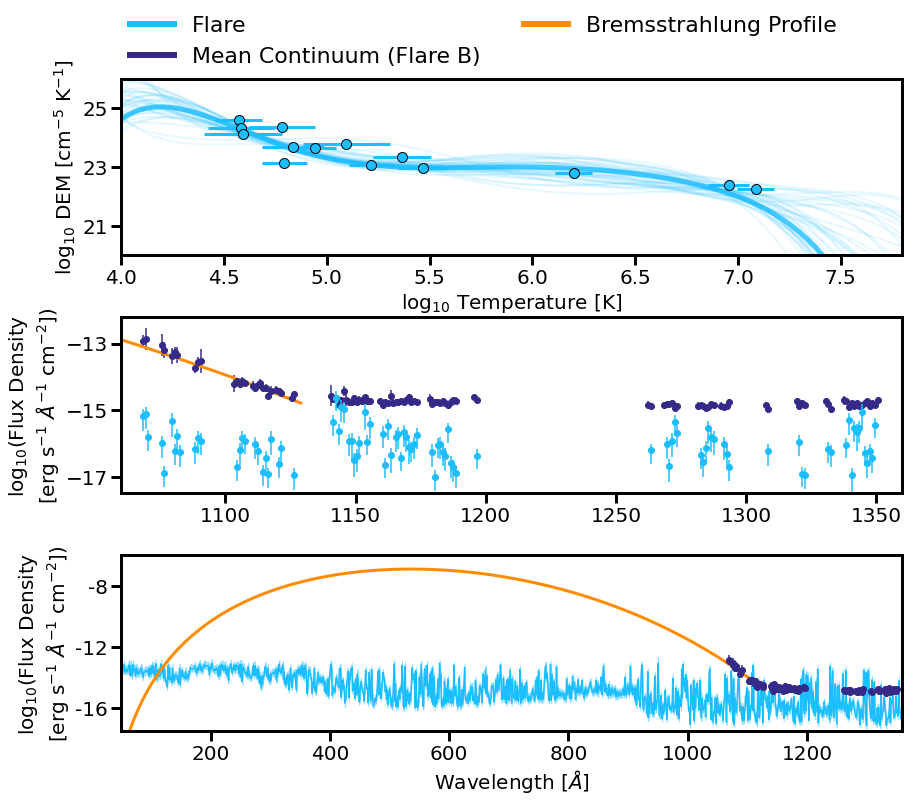

In [19]:
fig = plt.figure(figsize=(14,12))
gs = GridSpec(nrows=3, ncols=2, figure=fig)
fig.set_facecolor('w')

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])

####################################################
############# FIRST PLOT :  DEM MODEL ##############
####################################################

plot_dem(ax1, fitsf, label='Flare', color=hdlc)

ax1.plot(np.arange(3,4,2), np.arange(100,101,2), parula[0], lw=3, 
         label='Mean Continuum (Flare B)')
ax1.plot(np.arange(3,4,2), np.arange(100,101,2),
         'darkorange', label='Bremsstrahlung Profile', lw=3)

lgd = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=2,  borderaxespad=0.,
                 frameon=False, fontsize=22)
for handle in lgd.legendHandles:
    handle.set_linewidth(6)
    handle.set_alpha(1)

ax1.set_xlabel('log$_{10}$ Temperature [K]', fontsize=20)
ax1.set_ylabel('log$_{10}$ DEM [cm$^{-5}$ K$^{-1}$]', fontsize=20)
ax1.set_ylim(20,26)
ax1.set_yticks(np.arange(21,27,2))
ax1.set_xlim(4,7.8)

####################################################
########### SECOND PLOT : BINNED SPECTRA ###########
####################################################
ax2.errorbar(continuum['wavelength'], continuum['log_flux'],
             continuum['log_flux_err'],
             marker='o', c=parula[0], linestyle='')

twin = ax2.twinx()
twin.errorbar(binned_dem.time.value,
             binned_dem.flux, 
             yerr=binned_dem.flux_err,
             marker='o', c=hdlc, linestyle='')
twin.set_yscale('log')

ax2.plot(brem['wavelength'], brem['brem_fit'],
         'darkorange', lw=3)

ax2.set_ylim(-17.5, -12.2)
ax2.set_yticks([-17, -15, -13])
twin.set_ylim(10**-17.5, 10**-12.2)
twin.set_yticks([])
#ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('log$_{10}$(Flux Density\n[erg s$^{-1}$ $\AA^{-1}$ cm$^{-2}$])')
ax2.set_xlim(1060,1360)

####################################################
############# THIRD PLOT : 50-1000 AA ##############
####################################################
plot_dem_spect(ax3, fw, ff, fl, fu, color=hdlc)


twin = ax3.twinx()
twin.plot(brem['wavelength'], brem['brem_fit'],
         'darkorange', lw=3)
twin.errorbar(continuum['wavelength'], continuum['log_flux'],
             continuum['log_flux_err'],
             marker='o', c=parula[0], linestyle='')

ax3.set_yscale('log')
ax3.set_ylim(10**-17.5, 10**-6)
twin.set_ylim(-17.5, -6)
twin.set_yticks([])
ax3.set_yticks([10**-16, 10**-12, 10**-8])
ax3.set_yticklabels(['-16', '-12', '-8'])
ax3.set_xlabel('Wavelength [$\AA$]')
ax3.set_ylabel('log$_{10}$(Flux Density\n[erg s$^{-1}$ $\AA^{-1}$ cm$^{-2}$])')
ax3.set_xlim(50,1360)

plt.subplots_adjust(hspace=0.35)
#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/dem_comp_flare.pdf',
#            rasterize=True, bbox_inches='tight', dpi=250)